In [ ]:
!labelme

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras import mixed_precision

import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
import pandas as pd


#* autoreload to reload modules
%load_ext autoreload
%autoreload 2

#* import custom modules
#from process import *
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

In [ ]:
def load_image(x):
    byte_img  = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=3)

    return img

class_dict = {
    'no face' : 0,
    'happy' : 1,
    'sad' : 2,
    'natural' : 3,
    'surprised' : 4,
    'angry' : 5,
}

reverse_dict  = {v:k for k,v in class_dict.items()}

aug_train_df = pd.read_csv('aug_data/train/train_data.csv')
aug_val_df = pd.read_csv('aug_data/val/val_data.csv')

def load_dataset_from_df(df, class_dict = class_dict ):
    #aug_train_df['bbox'] = aug_train_df['bbox'].apply(lambda x: eval(x))
    df['bbox'] = df['bbox'].apply(lambda x:eval(x))
    df['xmin'] = df['bbox'].apply(lambda x: x[0]).astype('float32')
    df['ymin'] = df['bbox'].apply(lambda x: x[1]).astype('float32')
    df['xmax'] = df['bbox'].apply(lambda x: x[2]).astype('float32')
    df['ymax'] = df['bbox'].apply(lambda x: x[3]).astype('float32')
    df['labels'] = df['labels'].apply(lambda x: class_dict[x]).astype('float32')

    #* one hot encoding
    onehot_labels = tf.keras.utils.to_categorical(df['labels'], num_classes=6)
    onehot_labels = tf.convert_to_tensor(onehot_labels, dtype=tf.float32)

    dataset_label = tf.data.Dataset.from_tensor_slices(onehot_labels)
    # aug_train_df.drop('bbox', axis=1, inplace=True)
    dataset_images = tf.data.Dataset.from_tensor_slices(df[['images']])
    dataset_images = dataset_images.map(lambda x: load_image(x[0]))
    dataset_images = dataset_images.map(lambda x : tf.image.resize(x, (120, 120)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset_images = dataset_images.map(lambda x : x/255, num_parallel_calls=tf.data.AUTOTUNE)

    data_set_coords = tf.data.Dataset.from_tensor_slices((df[['xmin', 'ymin', 'xmax', 'ymax']]))
    
    dataset = tf.data.Dataset.zip((dataset_label , data_set_coords))
    dataset = tf.data.Dataset.zip((dataset_images, dataset ))
    
    return dataset

train = load_dataset_from_df(aug_train_df)
#* for prediction
## reverse_dict[y[0].argmax()]
val = load_dataset_from_df(aug_val_df)

## Building the new model

In [ ]:
size = (120, 120)
batch_size = 8
train = train.batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(1000)
val = val.batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(1000)

In [ ]:
def build_model(size=size):
    input_layer = Input(shape=(size[0],size[1], 3))
    vgg = VGG16(include_top=False)(input_layer)

    #* 1 for classification
    f1 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(6, activation='softmax')(class1)
    # class2 = tf.cast(class2, tf.float16)

    #* 4 for bounding box
    f2 = tf.keras.layers.GlobalAveragePooling2D()(vgg)
    reggress1 = Dense(2048, activation='relu')(f2)
    reggress2 = Dense(4, activation='sigmoid')(reggress1)
    #reggress2 = tf.cast(reggress2, tf.float16)

    face_tracker = Model(inputs = input_layer, outputs = [class2, reggress2])

    return face_tracker

face_tracker = build_model()
#face_tracker.summary()

In [ ]:
batches_per_epoch = len(train) // batch_size
lr_decay = (1./0.75 - 1) / (batches_per_epoch)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - y_pred[:, :2]))
    
    try :
        h_true = y_true[:, 3]  - y_true[:, 1]
        w_true = y_true[:, 2]  - y_true[:, 0]
        
        h_pred = y_pred[:, 3]  - y_pred[:, 1]
        w_pred = y_pred[:, 2]  - y_pred[:, 0]
    except Exception as e:
        print(e)
        print(y_true)
        print(y_pred)
        raise e
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    # delta_size = tf.reduce_sum(tf.square(tf.sqrt(w_true) - tf.sqrt(w_pred)) + tf.square(tf.sqrt(h_true) - tf.sqrt(h_pred)))    
    
    return delta_coord + 0.5*delta_size

classification_loss = tf.keras.losses.CategoricalCrossentropy()
regression_loss = localization_loss

# def total_loss (y_true, y_pred):
#     class_loss = tf.keras.losses.BinaryCrossentropy()(y_true[0], y_pred[0])
#     regression_loss = localization_loss(y_true[1], y_pred[1])
#     return class_loss + regression_loss

In [ ]:
class FaceTracker(Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.coord_track = []
        
    def compile(self, optimizer, class_loss, regression_loss, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.class_loss = class_loss
        self.regression_loss = regression_loss
        
    def train_step(self, batch, **kwargs):
        x, y = batch
        
        with tf.GradientTape() as tape:
            #* predict
            classes, coords = self.model(x, training=True)
            #self.coord_track.append(coords)
            #* calculate loss
            batch_class_loss = self.class_loss(y[0], classes)
            batch_regression_loss = self.regression_loss(y[1], coords)
            
            #* total loss
            total_loss = 2*batch_regression_loss + batch_class_loss
            
            #* get gradients
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        #* update weights
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        return {'loss': total_loss, 'class_loss': batch_class_loss, 'regression_loss': batch_regression_loss}
    
    def test_step(self, batch, **kwargs):
        x, y = batch
        
        classes, coords = self.model(x, training=False)
        batch_class_loss = self.class_loss(y[0], classes)
        batch_regression_loss = self.regression_loss(y[1], coords)
        
        total_loss = batch_regression_loss +  batch_class_loss
        return {'loss': total_loss, 'class_loss': batch_class_loss, 'regression_loss': batch_regression_loss}
        
    def call(self, x, **kwargs):
        return self.model(x, **kwargs)

In [ ]:
#* save best model
import os
if not os.path.exists('models'):
    os.mkdir('models')
checkpoint_path = "models/ER_model.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

#* early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=25,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [ ]:
#hist = model.fit(train, epochs=500, validation_data=val, callbacks=[model_checkpoint, early_stopping])

In [ ]:
face_tracker = build_model()
model = FaceTracker(face_tracker)
model.compile(optimizer=opt, class_loss=classification_loss, regression_loss=regression_loss)
model.built = True
model.load_weights('models/ER_model.h5')

class_dict = {
    'no face' : 0,
    'happy' : 1,
    'sad' : 2,
    'natural' : 3,
    'surprised' : 4,
    'angry' : 5,
}

reverse_dict  = {v:k for k,v in class_dict.items()}

In [ ]:
path = r'aug_data\val\images\3c86f828-e836-11ed-a2ea-60189528f842_0.jpg'
img  = cv2.imread(path)
resized_img = np.expand_dims(cv2.resize(img, (120, 120))/255.0, axis=0)
pred = model.predict(resized_img)

cv2.rectangle(
    img, 
    pt1= (int(pred[1][0][0]*img.shape[1]), int(pred[1][0][1]*img.shape[0])),
    pt2= (int(pred[1][0][2]*img.shape[1]), int(pred[1][0][3]*img.shape[0])),
    color=(0, 255, 0),  
    thickness=2
)
plt.title(reverse_dict[pred[0].argmax(axis=1)[0]])
plt.imshow(img)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_7[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_3 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 Max

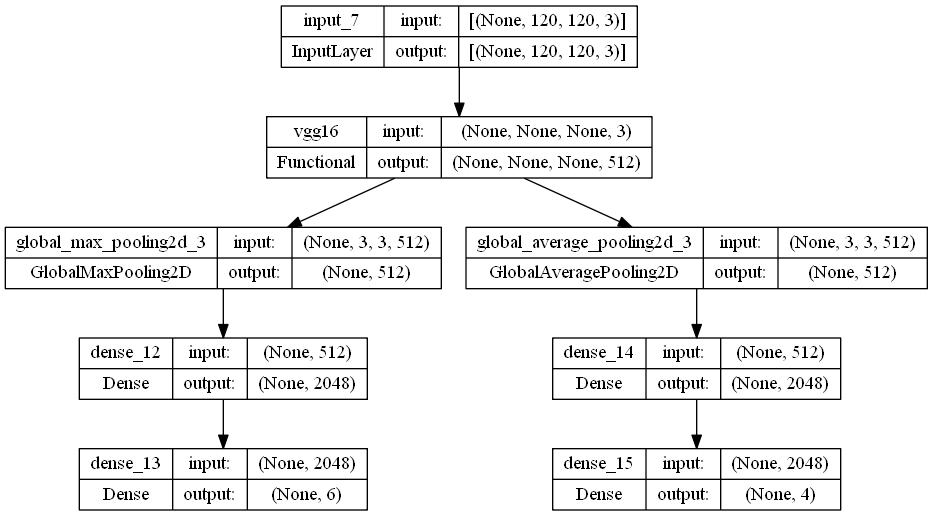

In [4]:
from engine import *
import cv2 
import numpy as np
from matplotlib import pyplot as plt

#* autoreload to reload modules
%load_ext autoreload
%autoreload 2

face_tracker = build_model()
model = FaceTracker(face_tracker)
#model.compile(optimizer=opt, class_loss=classification_loss, regression_loss=regression_loss)
model.built = True
model.load_weights('models/ER_model.h5')

class_dict = {
    'no face' : 0,
    'happy' : 1,
    'sad' : 2,
    'natural' : 3,
    'surprised' : 4,
    'angry' : 5,
}

reverse_dict  = {v:k for k,v in class_dict.items()}

#model.summary()
face_tracker.summary()

display(tf.keras.utils.plot_model(face_tracker, to_file='misc/model.png', show_shapes=True))